#### using the scoring math from reefscape utils
#### 20250215 CJH

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output
from importlib import reload 
import reefscape_utils as ru

In [3]:
reload (ru)

<module 'reefscape_utils' from 'C:\\CJH\\Python\\FRC\\2025\\resources\\plots\\reefscape_utils.py'>

#### making trajectory guidelines - looks like we should come up one inch on the elevator as we continue down another 10 degrees

In [4]:
data = {}
for bottom in range(6,1,-1):
    engagement_positions = {key: ru.solve_engagement(val["height"], val["x"], val["offset"], bottom) for key, val in ru.target_pipes.items()}
    data[bottom]= engagement_positions
df = pd.DataFrame(data).transpose()

In [5]:
df['DEPTH'] = df.index
df = df[['DEPTH', 'H4', 'H3', 'H2', 'H1']]
df

,DEPTH,H4,H3,H2,H1
6,6,"{'H': 57.16, 'THETA': 47.25, 'offset': -2}","{'H': 29.99, 'THETA': 53.72, 'offset': 0}","{'H': 14.09, 'THETA': 53.72, 'offset': 0}","{'H': 7.1, 'THETA': 37.41, 'offset': 0}"
5,5,"{'H': 57.53, 'THETA': 44.43, 'offset': -2}","{'H': 30.32, 'THETA': 51.04, 'offset': 0}","{'H': 14.42, 'THETA': 51.04, 'offset': 0}","{'H': 7.62, 'THETA': 34.22, 'offset': 0}"
4,4,"{'H': 57.85, 'THETA': 41.67, 'offset': -2}","{'H': 30.59, 'THETA': 48.41, 'offset': 0}","{'H': 14.69, 'THETA': 48.41, 'offset': 0}","{'H': 8.07, 'THETA': 31.15, 'offset': 0}"
3,3,"{'H': 58.1, 'THETA': 39.01, 'offset': -2}","{'H': 30.8, 'THETA': 45.85, 'offset': 0}","{'H': 14.9, 'THETA': 45.85, 'offset': 0}","{'H': 8.43, 'THETA': 28.21, 'offset': 0}"
2,2,"{'H': 58.28, 'THETA': 36.45, 'offset': -2}","{'H': 30.96, 'THETA': 43.37, 'offset': 0}","{'H': 15.06, 'THETA': 43.37, 'offset': 0}","{'H': 8.7, 'THETA': 25.44, 'offset': 0}"


#### how to use feedforwards

In [6]:
import wpimath.controller

In [88]:
elevator_ff = wpimath.controller.ElevatorFeedforward(
                kS=0, kG=.44, kV=12.05, kA=.1, dt=0.02)
pivot_ff = wpimath.controller.ArmFeedforward(
                kS=0, kG=0.7, kV=1.69, kA=.02, dt=0.02)

In [98]:
# as fast as we can reasonably expect to go with 12 V - plug in to find max values
pivot_max_velocity = 6.6; elevator_max_velocity = 0.95
pivot_max_volts = pivot_ff.calculate(0,pivot_max_velocity)
elevator_max_volts = elevator_ff.calculate(elevator_max_velocity)
pivot_max_volts, elevator_max_volts

(11.854, 11.8875)

In [115]:
velocity_elevator = np.linspace(0, elevator_max_velocity, 100)  # generate velocities for elevator
velocity_pivot = np.linspace(0, pivot_max_velocity, 100)  # generate velocites for pivot
volts_elevator = [elevator_ff.calculate(i) for i in velocity_elevator]  # calculate voltage for each elevator velocity
volts_pivot_flat = [pivot_ff.calculate(0,i) for i in velocity_pivot]  # calculate voltage for pivot velocities with pivot flat
volts_pivot_up = [pivot_ff.calculate(1.57,i) for i in velocity_pivot]  # calculate voltage for pivot velocities with pivot up

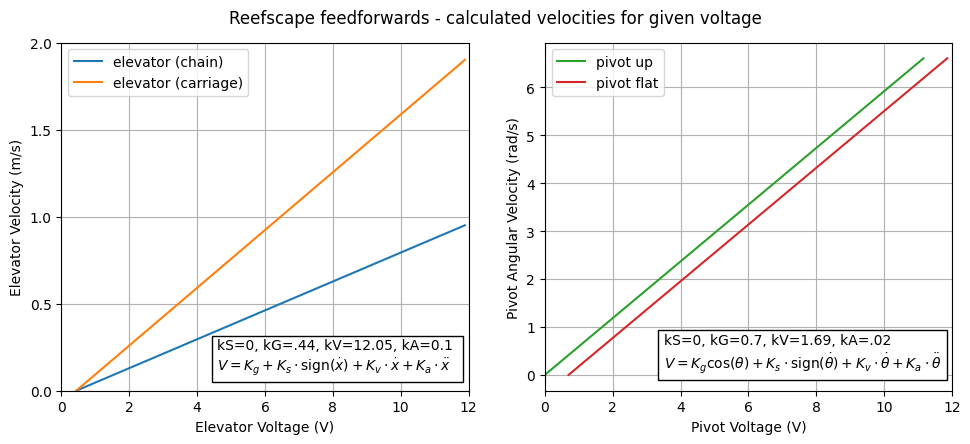

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Plot 1 (Elevator)
axs[0].plot(volts_elevator, velocity_elevator, label='elevator (chain)')  # Correct order: volts, velocity
axs[0].plot(volts_elevator, 2*velocity_elevator, label='elevator (carriage)')  # Correct order: volts, velocity
axs[0].set_xlabel("Elevator Voltage (V)")
axs[0].set_ylabel("Elevator Velocity (m/s)")
axs[0].set_ylim(0, 2)  # X-axis (Volts) limits
axs[0].set_yticks(np.arange(0, 2.5, 0.5))  # Set y-ticks every 0.5
equation_text = r"$V = K_g + K_s \cdot \text{sign}(\dot{x}) + K_v \cdot \dot{x} + K_a \cdot \ddot{x}$"  # Use raw string and LaTeX
axs[0].text(4.6, 0.12, f'kS=0, kG=.44, kV=12.05, kA=0.1 \n{equation_text}', fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))

# Plot 2 (Pivot)
axs[1].plot(volts_pivot_up, velocity_pivot, label='pivot up', color='C2' )  # Correct order: volts, velocity
axs[1].plot(volts_pivot_flat, velocity_pivot, label='pivot flat', color='C3' )  # Correct order: volts, velocity
axs[1].set_xlabel("Pivot Voltage (V)")
axs[1].set_ylabel("Pivot Angular Velocity (rad/s)")
equation_text = r"$V = K_g \cos(\theta) + K_s \cdot \text{sign}(\dot{\theta}) + K_v \cdot \dot{\theta} + K_a \cdot \ddot{\theta}$"
axs[1].text(3.5, 0.15, f'kS=0, kG=0.7, kV=1.69, kA=.02\n{equation_text}', fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))

# common to both
for idx in [0,1]:
    axs[idx].set_xlim(0, 12)  # X-axis (Volts) limits
    axs[idx].legend()
    axs[idx].grid('on')
    
# Overall Title
fig.suptitle('Reefscape feedforwards - calculated velocities for given voltage', fontsize=12, y=0.91)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()